In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
import pandas as pd
import numpy as np
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt
import torch

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
sys.path.append(os.path.join(os.getcwd(), '..'))
from symlie.misc.utils import NumpyUtils, Results, tensor_operation, numpy_operation, Args
from symlie.misc.viz import plot2d
from symlie.model.setup import find_id_for_P, load_P_pred
from symlie.model.networks.linear import CalculatedP
from symlie.misc.viz import plot2d
from symlie.data.generate_2d import sine1d, sine2d, flower, mnist
from symlie.data.generate_data import datasets
from symlie.data.dataset import FlatDataset

from symlie.misc.utils_results import plot_data, assert_unique, pivot, plot_pivot, add_df_map_new, assert_columns_same, get_and_check_Ps, plot_seeds_and_Ps, rename_net, stringify_dict
from symlie.misc.wandb import exceptions, new_runs, update_results_df, get_inspect_df

In [5]:
# check_df = 'results'
# reload = False

check_df = 'inspect'
reload = False


match check_df:
    case 'results':
        if reload:
            update_results_df()
        df = pd.read_pickle('../logs/store/results_df.pkl')
    case 'inspect':
        df_inspect = get_inspect_df(reload = reload)
        df = df_inspect

print(df.shape)
print(df.columns)
df.head()

Retreiving wandb gt6i9kse: 100%|██████████| 48/48 [00:09<00:00,  5.07it/s]

(48, 48)
Index(['lr', 'net', 'bias', 'name', 'seed', 'tags', 'test', 'A_low', 'n_val',
       'train', 'y_low', 'A_high', 'config', 'device', 'logger', 'n_test',
       'run_id', 'y_high', 'log_dir', 'n_train', 'predict', 'version',
       'y_multi', 'data_dir', 'eps_mult', 'n_splits', 'criterion', 'do_return',
       'earlystop', 'grid_size', 'n_classes', 'noise_std', 'only_flip',
       'batch_size', 'max_epochs', 'data_kwargs', 'num_workers',
       'out_features', 'generate_data', 'model_summary', 'args_processed',
       'do_return_model', 'n_hidden_layers', 'transform_kwargs',
       'use_P_from_noise', 'persistent_workers', 'run_name', 'test_loss'],
      dtype='object')


,lr,net,bias,name,seed,tags,test,A_low,n_val,train,...,generate_data,model_summary,args_processed,do_return_model,n_hidden_layers,transform_kwargs,use_P_from_noise,persistent_workers,run_name,test_loss
0,0.001,Predict-NoiseTrainedP,False,None,3,"[dev, inspect, sine1d-noise-predict]",True,None,1000,True,...,False,False,True,False,1,"{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",True,True,genial-elevator-2204,0.147123
1,0.010,Predict-NoiseTrainedP,False,None,3,"[dev, inspect, sine1d-noise-predict]",True,None,1000,True,...,False,False,True,False,1,"{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",True,True,mild-jazz-2205,0.148539
2,0.001,Predict-NoiseTrainedP,False,None,3,"[dev, inspect, sine1d-noise-predict]",True,None,1000,True,...,False,False,True,False,1,"{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",True,True,mild-deluge-2202,0.215161
3,0.010,Predict-NoiseTrainedP,False,None,3,"[dev, inspect, sine1d-noise-predict]",True,None,1000,True,...,False,False,True,False,1,"{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",True,True,lively-durian-2202,0.176656
4,0.001,Predict-NoiseTrainedP,False,None,2,"[dev, inspect, sine1d-noise-predict]",True,None,1000,True,...,False,False,True,False,1,"{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",True,True,cosmic-moon-2198,0.143675


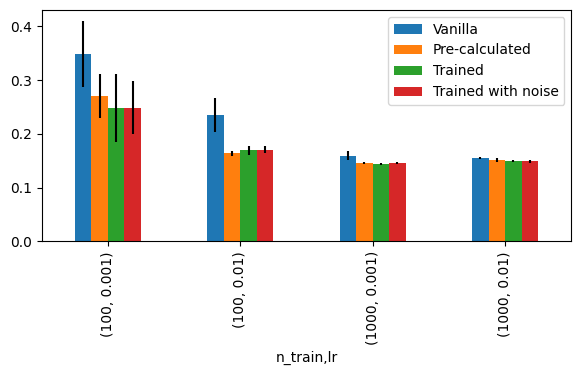

test_loss                       \
n_train                                              100                        
lr                                                 0.001                        
net                                              Vanilla       Pre-calculated   
dataset_name eps_mult     noise_std                                             
sine1d-noise [0, 0, 1, 0] 0.5        3.49e-01 ± 6.15e-02  2.71e-01 ± 4.09e-02   

                                                                               \
n_train                                                                         
lr                                                                              
net                                              Trained   Trained with noise   
dataset_name eps_mult     noise_std                                             
sine1d-noise [0, 0, 1, 0] 0.5        2.48e-01 ± 6.36e-02  2.48e-01 ± 4.95e-02   

                                                                               \
n_train                                                                         
lr                                                  0.01                        
net                                              Vanilla       Pre-calculated   
dataset_name eps_mult     noise_std                                             
sine1d-noise [0, 0, 1, 0] 0.5        2.35e-01 ± 3.08e-02  1.64e-01 ± 5.18e-03   

                                                                               \
n_train                                                                         
lr                                                                              
net                                              Trained   Trained with noise   
dataset_name eps_mult     noise_std                                             
sine1d-noise [0, 0, 1, 0] 0.5        1.70e-01 ± 8.00e-03  1.71e-01 ± 6.75e-03   

                                                                               \
n_train                                             1000                        
lr                                                 0.001                        
net                                              Vanilla       Pre-calculated   
dataset_name eps_mult     noise_std                                             
sine1d-noise [0, 0, 1, 0] 0.5        1.60e-01 ± 8.71e-03  1.45e-01 ± 1.92e-03   

                                                                               \
n_train                                                                         
lr                                                                              
net                                              Trained   Trained with noise   
dataset_name eps_mult     noise_std                                             
sine1d-noise [0, 0, 1, 0] 0.5        1.45e-01 ± 1.89e-03  1.46e-01 ± 1.75e-03   

                                                                               \
n_train                                                                         
lr                                                  0.01                        
net                                              Vanilla       Pre-calculated   
dataset_name eps_mult     noise_std                                             
sine1d-noise [0, 0, 1, 0] 0.5        1.55e-01 ± 2.29e-03  1.51e-01 ± 3.80e-03   

                                                                               
n_train                                                                        
lr                                                                             
net                                              Trained   Trained with noise  
dataset_name eps_mult     noise_std                                            
sine1d-noise [0, 0, 1, 0] 0.5        1.49e-01 ± 1.85e-03  1.49e-01 ± 2.01e-03

In [8]:
group_params = ['eps_mult', 'noise_std']
hyper_params  = ['n_train', 'lr', 'net']

datasets_new = [
    'sine1d',
    'sine2d',
    'flower',
    'mnist',
]

datasets_inspect = [
    'sine1d-noise',
    # 'sine1dlayers',
    # 'sine1dtwo-hparam',
]
datasets_predict = {'results' : datasets_new, 'inspect' : datasets_inspect}[check_df]

default_log = [
    'sine2d',
    # 'flower',
]

d_pivots = {}
index_columns = ['dataset_name'] + group_params
dds = []
dds_mean = []
dds_std = []

for dataset_name in datasets_predict:
    d = df[df['tags'].astype(str).str.contains(f'{dataset_name}-predict')].reset_index(drop=True)

    d = stringify_dict(d, group_params)
    ds = {group : d_group for group, d_group in d.groupby(group_params)} if group_params else {0 : d}

    for group, d in ds.items():

        d = d.reset_index(drop=True)

        for row in d['data_kwargs']:
            if 'grid_size' in row:
                row['grid_size'] = tuple(row['grid_size'])
        for row in d['transform_kwargs']:
            if 'eps_mult' in row:
                row['eps_mult'] = [float(x) for x in row['eps_mult']]


        _, noise_std = group
        if float(noise_std) == 0.0: continue


        d = d.drop_duplicates(subset=hyper_params + ['seed', 'test_loss']) #TODO: why is this necessary?
        assert_columns_same(d, ['data_kwargs', 'transform_kwargs', 'data_dir'])

        d_pivot = pivot(d, columns=hyper_params)
        d_pivot = rename_net(d_pivot)
        d_pivots[(dataset_name, group)] = dict(d_pivot=d_pivot)

        dd = pd.DataFrame(data = [f'{mean:.2e} ± {std:.2e}' for mean, std in zip(d_pivot.mean().values, d_pivot.std().values)], index = d_pivot.columns).T
        dd_mean = pd.DataFrame(data = [mean for mean in d_pivot.mean().values], index = d_pivot.columns).T
        dd_std = pd.DataFrame(data = [std for std in d_pivot.std().values], index = d_pivot.columns).T

        for dd_i, dds_i in zip([dd, dd_mean, dd_std], [dds, dds_mean, dds_std]):

            dd_i[index_columns] = [dataset_name] + list(group)
            dd_i = dd_i.set_index(index_columns)
            dds_i.append(dd_i)

        # continue
        logx = True if dataset_name in default_log else False
        suptitle = dataset_name + '\n' + ', '.join([f'{group_param} = {group_el}' for group_param, group_el in zip(group_params, group)]) if group != 0 else dataset_name
        # plot_pivot(d_pivot=d_pivot, legend_loc = 'upper right', logx=logx, suptitle = suptitle)
        plot_pivot(d_pivot=d_pivot, legend_loc = 'upper right', logx=logx, suptitle = None, figsize = (6, 4))

ddd = pd.concat(dds)
ddd_mean = pd.concat(dds_mean)
ddd_std = pd.concat(dds_std)
ddd

In [213]:
# mins = d_mean.loc[pd.IndexSlice[net_name, 100]].idxmin(axis=0)
# mins

In [214]:
d_mean = ddd_mean.T.reorder_levels(['net', 'n_train', 'lr', None],).sort_index()
d_std = ddd_std.T.reorder_levels(['net', 'n_train', 'lr', None],).sort_index()

In [215]:
d_mins = {}
for net_name in ['Vanilla', 'Trained']:
    n_trains = [100, 1000, 10000]
    d_min = pd.concat([d_mean.loc[pd.IndexSlice[net_name, n_train]].min(axis=0) for n_train in n_trains], axis=1)
    d_min.columns = n_trains
    d_mins[net_name] = d_min

d_min = pd.concat(d_mins, axis = 1)

In [219]:
title_dict = {
    'dataset' :{
        'sine1d' : 'Sine 1D',
        'sine2d' : 'Sine 2D',
        'flower' : 'Flower',
        'mnist' : 'MNIST',
    },
    'eps_mult' : {
        '[0, 0, 1, 0]' : r'$T(1)$',
        '[0, 0, 1, 1]' : r'$SO(2)$',
        '[0, 1, 1, 1]' : r'$SE(2)$',
    },
}

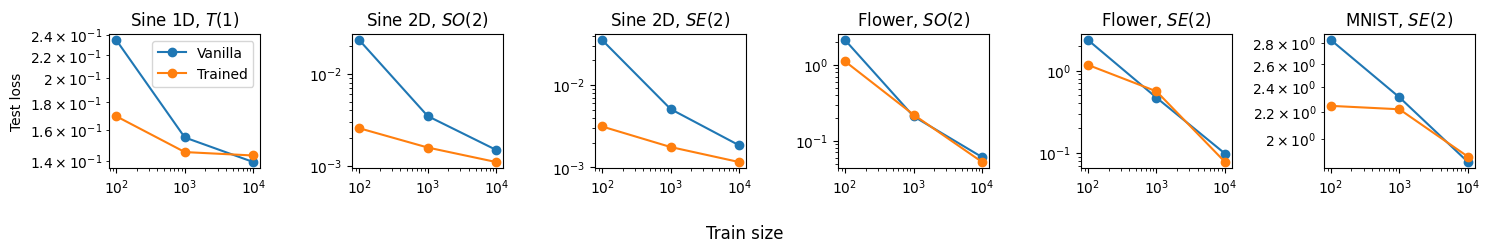

In [223]:
n_plot = len(d_min)
# fig, axs = plt.subplots(nrows=n_plot, figsize=(3, 3*n_plot))
fig, axs = plt.subplots(ncols=n_plot, figsize=(2.5*n_plot, 2.5), tight_layout = True, sharex=True, sharey=False)

for ax, (index, row) in zip(axs, d_min.iterrows()):

    dataset, eps_mult, noise_std = index

    for net_name in d_min.columns.get_level_values(0).unique():

        title = title_dict['dataset'][dataset] + ', ' + title_dict['eps_mult'][eps_mult]
        row[net_name].plot(marker = 'o', logx=True, logy=True, ax = ax, label = net_name, title = title)
axs[0].legend()
axs[0].set_ylabel('Test loss')
fig.supxlabel('Train size')
plt.show()


In [5]:
d = df.copy()

d = d[d['tags'].astype(str).str.contains('predict')].reset_index(drop=True)

d = stringify_dict(d, group_params)

print(d.shape)
dd = d.groupby(['data_dir'] + group_params + hyper_params + ['seed']).count()
print(dd[dd['test_loss'] > 1].index.values)
d = d.drop_duplicates(subset=hyper_params + ['seed', 'test_loss'])
print(d.shape)

d = pivot(d, index = ['data_dir'] + group_params , columns = hyper_params +  ['seed'], values = 'test_loss')

d = d.drop('Predict-CalculatedP', axis = 1, level = 3)

# d = d.iloc[:, d.columns.get_level_values(2) == 0.01]

# d.columns[d.isna().any(axis=0)]
d

(448, 47)
[]
(448, 47)


test_loss                      \
n_train                                       100                         
lr                                            0.001                       
net                                   Predict-NoneP                       
seed                                              1         2         3   
data_dir       eps_mult     noise_std                                     
../data/MNIST  [0, 1, 1, 1] 0.0            2.937259  2.844392  2.939889   
                            0.1                 NaN  2.831010  2.829965   
../data/flower [0, 0, 1, 1] 0.0            2.795511  2.113411  2.245426   
                            0.1            2.485707  2.338358  2.112234   
               [0, 1, 1, 1] 0.0            2.488744  2.381774  1.864164   
                            0.1            2.616742  2.260929  2.572932   
../data/sine1d [0, 0, 1, 0] 0.5            0.403021  0.281951  0.361086   
../data/sine2d [0, 0, 1, 1] 0.1            0.051421  0.059522  0.069186   
               [0, 1, 1, 1] 0.1            0.074101  0.079811  0.139475   

                                                                            \
n_train                                                                      
lr                                                                           
net                                   Predict-TrainedP                       
seed                                                 1         2         3   
data_dir       eps_mult     noise_std                                        
../data/MNIST  [0, 1, 1, 1] 0.0                    NaN  2.195672  2.242971   
                            0.1               2.306753  2.187653       NaN   
../data/flower [0, 0, 1, 1] 0.0               1.096170  1.120773  1.104059   
                            0.1               1.109006  1.128359  1.119107   
               [0, 1, 1, 1] 0.0                    NaN  1.039864  1.050125   
                            0.1                    NaN  1.171049       NaN   
../data/sine1d [0, 0, 1, 0] 0.5               0.321519  0.217177  0.206340   
../data/sine2d [0, 0, 1, 1] 0.1               0.003099  0.003470  0.003915   
               [0, 1, 1, 1] 0.1               0.003956  0.005743  0.006546   

                                                                         \
n_train                                                                   
lr                                            0.010                       
net                                   Predict-NoneP                       
seed                                              1         2         3   
data_dir       eps_mult     noise_std                                     
../data/MNIST  [0, 1, 1, 1] 0.0            4.217338  4.075702       NaN   
                            0.1            4.277594  4.368821  4.031054   
../data/flower [0, 0, 1, 1] 0.0            2.529043  1.898839  2.231631   
                            0.1            2.304017  2.099678  2.025271   
               [0, 1, 1, 1] 0.0                 NaN       NaN  1.910597   
                            0.1            2.467564  2.147691  2.438209   
../data/sine1d [0, 0, 1, 0] 0.5            0.249225  0.199787  0.256343   
../data/sine2d [0, 0, 1, 1] 0.1            0.022640  0.023749  0.023222   
               [0, 1, 1, 1] 0.1            0.038079  0.035776  0.032726   

                                                        ...                \
n_train                                                 ...         10000   
lr                                                      ...         0.010   
net                                   Predict-TrainedP  ... Predict-NoneP   
seed                                                 1  ...             3   
data_dir       eps_mult     noise_std                   ...                 
../data/MNIST  [0, 1, 1, 1] 0.0               2.529701  ...      2.004286   
                            0.1               2.479741  ...      1.969342   
../

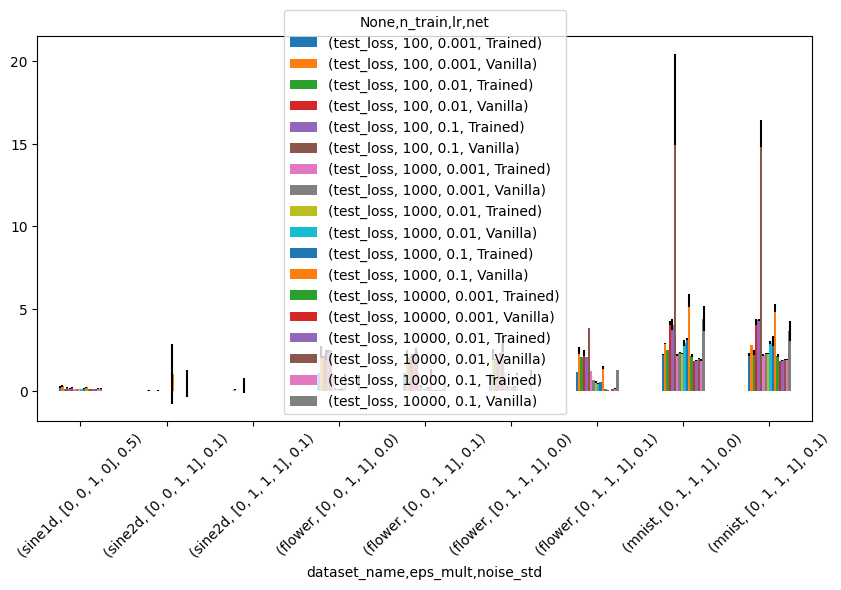

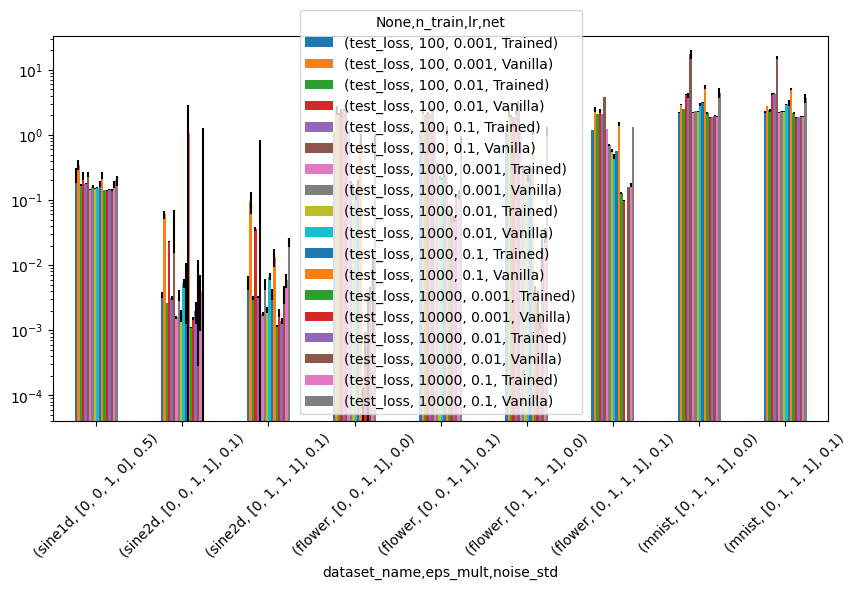

In [9]:
for logy in [False, True]:
    ddd_mean.plot(kind='bar', yerr = ddd_std, figsize = (10, 5), logy = logy, rot = 45)
    plt.show()

In [31]:
d_pivot['d_pivot']

test_loss                                                              \
n_train     100                                                         1000    
lr          0.001               0.010               0.100               0.001   
net       Trained   Vanilla   Trained   Vanilla   Trained   Vanilla   Trained   
seed                                                                            
1        1.096170  2.795511  2.058486  2.529043  2.377131  2.487784  1.123542   
2        1.120773  2.113411  2.147087  1.898839  2.499943  2.487313  1.127234   
3        1.104059  2.245426  2.037229  2.231631  2.353154  2.536069  1.123279   

                                                                               \
n_train                                                       10000             
lr                    0.010               0.100               0.001             
net       Vanilla   Trained   Vanilla   Trained   Vanilla   Trained   Vanilla   
seed                                                                            
1        0.199948  0.131988  0.097670  0.212402  0.998873  0.000061  0.000959   
2        0.140669  0.126832  0.122088  0.135457  0.653518  0.000022  0.000333   
3        0.168789  0.183096  0.126773  0.140881  0.943023  0.000139  0.000508   

                                                 
n_train                                          
lr          0.010               0.100            
net       Trained   Vanilla   Trained   Vanilla  
seed                                             
1        0.003788  0.004531  0.001021  0.690406  
2        0.001149  0.002677  0.014958  0.421215  
3        0.000024  0.003859  0.007408  1.027676

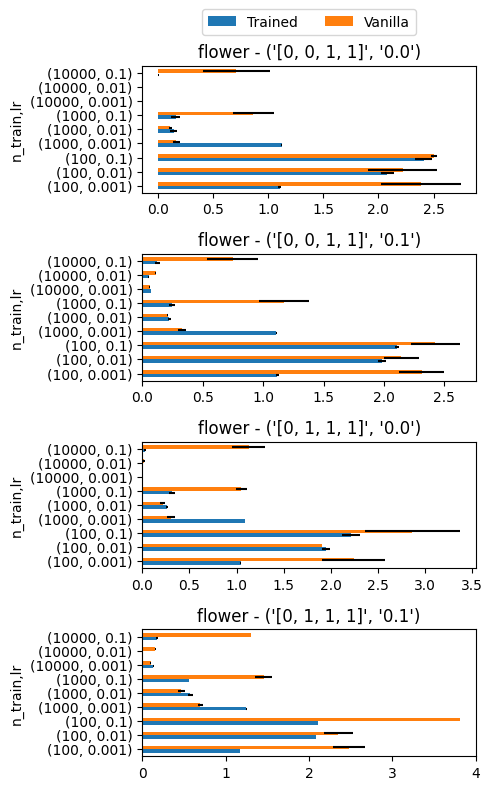

In [38]:
n_plots = len(d_pivots)
plot_dir = 'x'


(n_height, n_width) = (1, n_plots) if plot_dir == 'x' else (n_plots, 1)
fig, axs = plt.subplots(n_plots, 1, figsize=(5*n_height, 2*n_width), tight_layout=True)

for i, ((dataset_name, group), d_pivot_content) in enumerate(d_pivots.items()):
    d_pivot = d_pivot_content['d_pivot']
    ax = axs[i]

    unstack = lambda d, metric: d.apply(metric).unstack().reset_index(level=0, drop = True)
    d_mean, d_std = unstack(d_pivot, pd.Series.mean), unstack(d_pivot, pd.Series.std)

    d_mean.plot(kind='barh', xerr=d_std, ax = ax, legend = False)
    ax.set_title(f'{dataset_name} - {group}')
    if i == 0: ax.legend(loc = 'upper center', bbox_to_anchor=(0.5, 1.5), ncol = 2)
    
    if dataset_name in default_log: ax.set_xscale('log')